# mean Functional & Structural connectivity strength correlates of mean qMRI gradients

### Libraries

In [6]:
import os
import numpy as np
import nibabel as nb
import pandas as pd
import glob
import matplotlib.pyplot as plt
from nilearn import plotting
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.datasets import load_mask
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_parcellation
from brainspace.null_models import SpinPermutations
from brainstat.datasets import fetch_mask
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy import stats
import scipy as sp
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import rankdata
from scipy.linalg import eigh
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import copy
import cmocean
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from igraph import Graph
from neuromaps.datasets import fetch_fslr
from surfplot import Plot

### Load surfaces and masks

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Boolean mask
mask_surf = mask_5k != 0

f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

### Functions

## Functional Connectome

### Load cortico-cortical functional connectivity data

In [3]:
# Load CSV file containing subject and session information
csv_dir = '/host/percy/local_raid/youngeun/from_mica1/lists'
csv_file = f"10PNC_T1map.csv"
subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

# Extract subject and session information from each row
files = []
for index, row in subject_session_info.iterrows():
    info = row['info'].split(',')
    subject = index[4:]  # Extract subject ID
    session = info[0][4:].strip()  # Extract session ID
    files_fc = f"sub-{subject}/ses-03/func/desc-me_task-rest_bold/surf/*_surf-fsLR-5k_desc-FC.shape.gii"
    files.extend(glob.glob(files_fc))

# Load intensity profiles from each file
profiles = []
for file_path in files:
    profile_data = nb.load(file_path).darrays[0].data
    
    # Fisher transform
    FCz = np.arctanh(profile_data)
    
    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    profiles.append(FCz)
profiles = np.array(profiles)
fc = np.mean(profiles, axis=0)
fc_sym = np.triu(fc,1)+fc.T

/tmp/ipykernel_3955604/1656040227.py:21: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(profile_data)


In [4]:
# Consider the absolute value
fc_abs = np.abs(fc_sym)
# Compute weighted degree centrality measures from the connectivity data
fc_ctx = np.sum(fc_abs, axis=0)

### Degree centrality (*strength*) of $FC_{abs}$ 

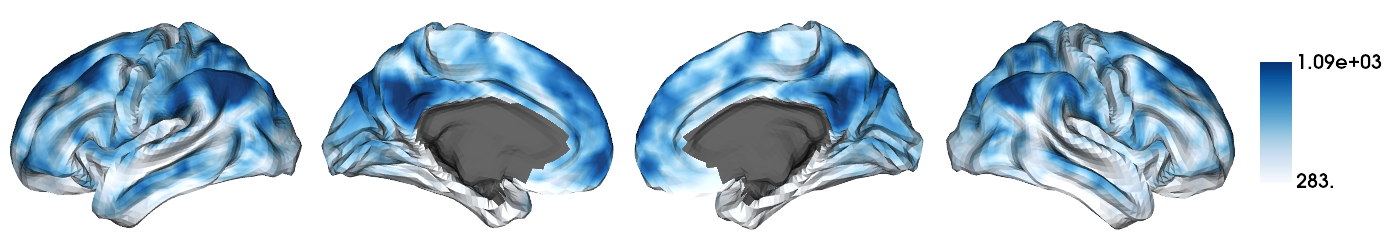

In [5]:
# Compute weighted degree centrality measures from the connectivity data
fc_ctx = np.sum(fc_abs, axis=0)

# Mask the midwall 
fc_ctx[mask_5k == False] = np.nan

# Calculate an optima range of color for visualization
crange=(np.quantile(fc_ctx[mask_5k != False], 0.075), np.quantile(fc_ctx[mask_5k != False], 0.98))

# plot the column mean of the mean connectome surface
plot_hemispheres(f5k_lh, f5k_rh, fc_ctx, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=crange,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

### FC sorted by gradients